In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import numpy as np
import pandas as pd 

In [4]:
import sys
sys.path.append('../../../')

In [5]:
import matplotlib.pyplot as plt 

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [7]:
from src.utils.dates import get_nyse_business_dates
from src.utils.io.read import PreprocessedDataReader

In [8]:
from src.preprocessing.base import FutureTicker

In [9]:
from src.settings import Settings

In [10]:
from research.metrics import get_features_responses_correlation
from research.plots import plot_bin_summary_of_xy

In [11]:
pdr = PreprocessedDataReader(Settings.historical.paths.PREPROCESSED_DATA_PATH)                    

In [12]:
dataset = pdr.read_dataset(ticker=FutureTicker.WTI)

In [13]:
dataset.shape

(813, 63)

In [14]:
dataset.tail(3)

,tradeDate,Name,Commercial_NetPosition,CommercialLongPosition,CommercialShortPosition,ManagedMoney_NetPosition,ManagedMoney_LongPosition,ManagedMoney_ShortPosition,Commercial_NetPosition_change,prior_report_Commercial_NetPosition_change,...,forward_CommercialShortPosition_to_openinterest_change,ManagedMoney_NetPosition_to_openinterest_change,prior_report_ManagedMoney_NetPosition_to_openinterest_change,forward_ManagedMoney_NetPosition_to_openinterest_change,ManagedMoney_LongPosition_to_openinterest_change,prior_report_ManagedMoney_LongPosition_to_openinterest_change,forward_ManagedMoney_LongPosition_to_openinterest_change,ManagedMoney_ShortPosition_to_openinterest_change,prior_report_ManagedMoney_ShortPosition_to_openinterest_change,forward_ManagedMoney_ShortPosition_to_openinterest_change
810,2025-07-15,CL,368688.0,1226014.0,857326.0,217954.0,404769.0,186815.0,31871.0,25279.0,...,-0.004796,-0.027664,-0.020086,-0.001610,-0.021889,-0.015015,0.006267,0.005775,0.005071,0.007877
811,2025-07-22,CL,355309.0,1179861.0,824552.0,208836.0,406472.0,197636.0,-13379.0,31871.0,...,-0.010335,-0.001610,-0.027664,-0.001536,0.006267,-0.021889,0.000810,0.007877,0.005775,0.002346
812,2025-07-29,CL,362436.0,1172427.0,809991.0,207342.0,411275.0,203933.0,7127.0,-13379.0,...,NaN,-0.001536,-0.001610,NaN,0.000810,0.006267,NaN,0.002346,0.007877,NaN


In [15]:
dataset['tradeDate'].min(),dataset['tradeDate'].max()

('2010-01-05', '2025-07-29')

In [16]:
dataset.columns.tolist()

['tradeDate',
 'Name',
 'Commercial_NetPosition',
 'CommercialLongPosition',
 'CommercialShortPosition',
 'ManagedMoney_NetPosition',
 'ManagedMoney_LongPosition',
 'ManagedMoney_ShortPosition',
 'Commercial_NetPosition_change',
 'prior_report_Commercial_NetPosition_change',
 'CommercialLongPosition_change',
 'prior_report_CommercialLongPosition_change',
 'CommercialShortPosition_change',
 'prior_report_CommercialShortPosition_change',
 'ManagedMoney_NetPosition_change',
 'prior_report_ManagedMoney_NetPosition_change',
 'ManagedMoney_LongPosition_change',
 'prior_report_ManagedMoney_LongPosition_change',
 'ManagedMoney_ShortPosition_change',
 'prior_report_ManagedMoney_ShortPosition_change',
 'F1_RolledPrice',
 'F2_RolledPrice',
 'F3_RolledPrice',
 'F1_RolledPrice_rolling_20D_volatility',
 'F2_RolledPrice_rolling_20D_volatility',
 'F3_RolledPrice_rolling_20D_volatility',
 'SyntheticF1MinusF2_RolledPrice',
 'prior_report_SyntheticF1MinusF2_RolledPrice_change',
 'prior_cumulative_5D_F1_V

In [17]:
dataset['tradeDate'] = pd.to_datetime(dataset['tradeDate']).dt.date 

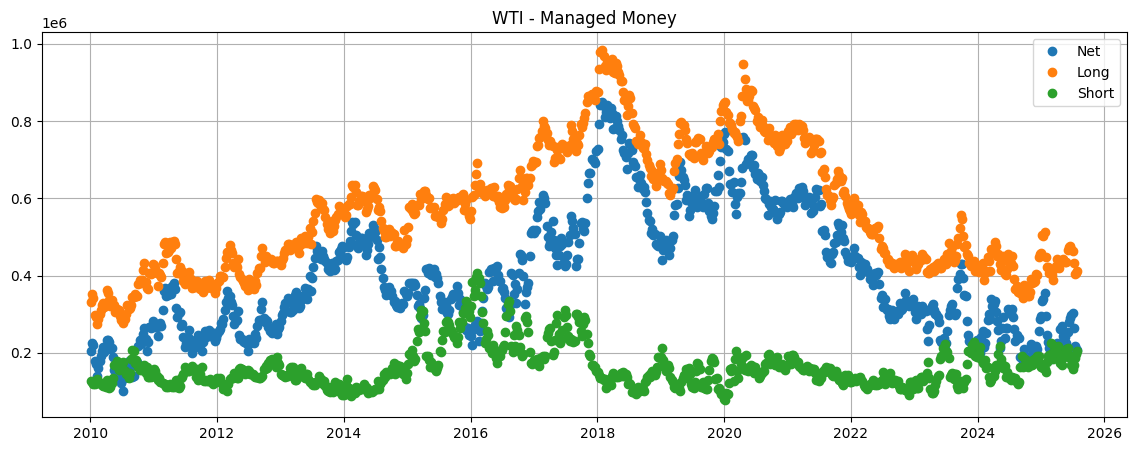

In [18]:
plt.rcParams["figure.figsize"] = (14,5)
plt.plot_date(dataset['tradeDate'],dataset['ManagedMoney_NetPosition'])
plt.plot_date(dataset['tradeDate'],dataset['ManagedMoney_LongPosition'])
plt.plot_date(dataset['tradeDate'],dataset['ManagedMoney_ShortPosition'])
plt.legend(['Net', 'Long', 'Short'])
plt.title('WTI - Managed Money')
plt.grid()

In [19]:
dataset['tradeDate'] = pd.to_datetime(dataset['tradeDate'])

dataset['year']=dataset['tradeDate'].dt.year

In [20]:
dataset['day_of_week'] = dataset['tradeDate'].dt.day_name()

In [21]:
dataset['day_of_week'].unique()

array(['Tuesday'], dtype=object)

In [22]:
dataset.sort_values(by = 'tradeDate', ascending = True, inplace = True)

In [23]:
for feature_name in [
                    'ManagedMoney_NetPosition',
                    'ManagedMoney_LongPosition', 
                    'ManagedMoney_ShortPosition']:
    dataset[f'prior_report_{feature_name}_change'] = dataset[feature_name]- dataset[feature_name].shift(1)
    
    

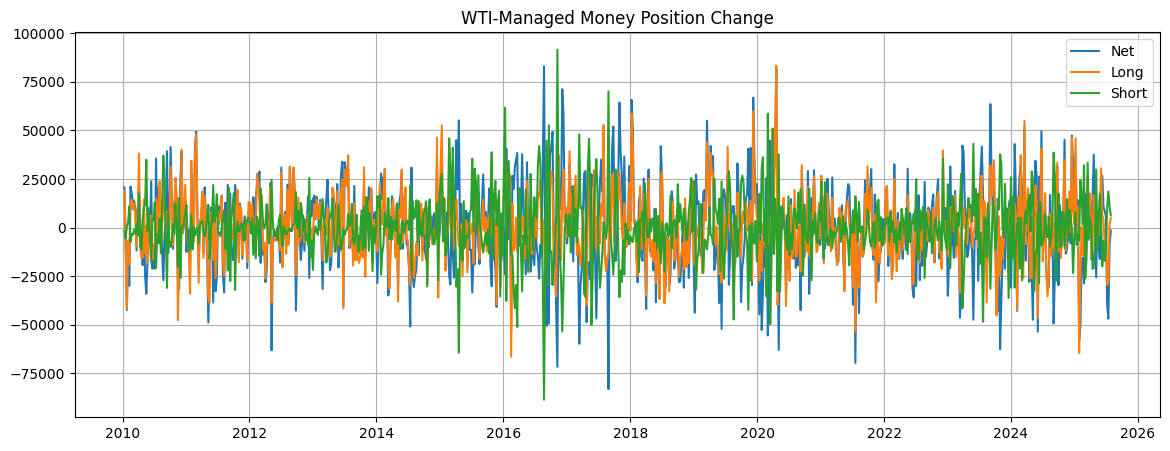

In [24]:
plt.rcParams["figure.figsize"] = (14,5)
plt.plot_date(dataset['tradeDate'],dataset['prior_report_ManagedMoney_NetPosition_change'], '-')
plt.plot_date(dataset['tradeDate'],dataset['prior_report_ManagedMoney_LongPosition_change'], '-')
plt.plot_date(dataset['tradeDate'],dataset['prior_report_ManagedMoney_ShortPosition_change'], '-')
plt.legend(['Net', 'Long', 'Short'])
plt.title('WTI-Managed Money Position Change')
plt.grid()

In [25]:
dataset.columns.tolist()

['tradeDate',
 'Name',
 'Commercial_NetPosition',
 'CommercialLongPosition',
 'CommercialShortPosition',
 'ManagedMoney_NetPosition',
 'ManagedMoney_LongPosition',
 'ManagedMoney_ShortPosition',
 'Commercial_NetPosition_change',
 'prior_report_Commercial_NetPosition_change',
 'CommercialLongPosition_change',
 'prior_report_CommercialLongPosition_change',
 'CommercialShortPosition_change',
 'prior_report_CommercialShortPosition_change',
 'ManagedMoney_NetPosition_change',
 'prior_report_ManagedMoney_NetPosition_change',
 'ManagedMoney_LongPosition_change',
 'prior_report_ManagedMoney_LongPosition_change',
 'ManagedMoney_ShortPosition_change',
 'prior_report_ManagedMoney_ShortPosition_change',
 'F1_RolledPrice',
 'F2_RolledPrice',
 'F3_RolledPrice',
 'F1_RolledPrice_rolling_20D_volatility',
 'F2_RolledPrice_rolling_20D_volatility',
 'F3_RolledPrice_rolling_20D_volatility',
 'SyntheticF1MinusF2_RolledPrice',
 'prior_report_SyntheticF1MinusF2_RolledPrice_change',
 'prior_cumulative_5D_F1_V

In [26]:
dataset[['prior_report_ManagedMoney_NetPosition_change',
 'prior_report_ManagedMoney_LongPosition_change',
 'prior_report_ManagedMoney_ShortPosition_change']].corr()

,prior_report_ManagedMoney_NetPosition_change,prior_report_ManagedMoney_LongPosition_change,prior_report_ManagedMoney_ShortPosition_change
prior_report_ManagedMoney_NetPosition_change,1.000000,0.698501,-0.621236
prior_report_ManagedMoney_LongPosition_change,0.698501,1.000000,0.126835
prior_report_ManagedMoney_ShortPosition_change,-0.621236,0.126835,1.000000


In [27]:
import scipy.stats as stats


<Axes: >

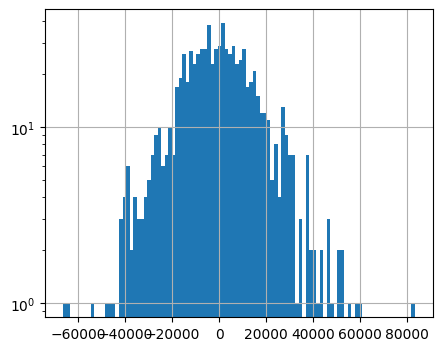

In [28]:
plt.rcParams["figure.figsize"] = (5,4)
dataset['prior_report_ManagedMoney_LongPosition_change'].hist(bins=100, log=True)

<Axes: >

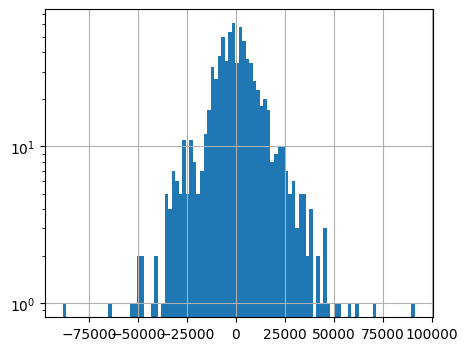

In [29]:
plt.rcParams["figure.figsize"] = (5,4)
dataset['prior_report_ManagedMoney_ShortPosition_change'].hist(bins=100, log=True)

<Axes: >

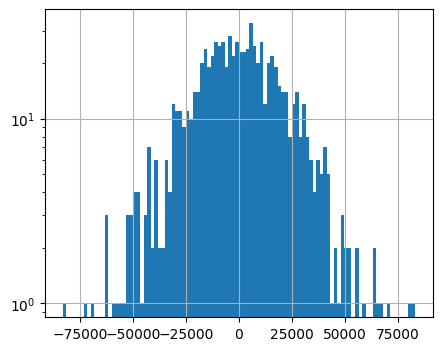

In [30]:
plt.rcParams["figure.figsize"] = (5,4)
dataset['prior_report_ManagedMoney_NetPosition_change'].hist(bins=100, log=True)

In [31]:
from research.eda.probability_distributions import test_normality_shapiro

In [33]:
result = test_normality_shapiro(
    dataset['prior_report_ManagedMoney_NetPosition_change']
)
print(result)


{'statistic': np.float64(0.9955140713293777), 'p_value': np.float64(0.018395432279833705), 'alpha': 0.05, 'verdict': 'Not normal'}


In [34]:
result = test_normality_shapiro(
    dataset['prior_report_ManagedMoney_LongPosition_change']
)
print(result)

{'statistic': np.float64(0.9901372663808382), 'p_value': np.float64(2.8819000902443288e-05), 'alpha': 0.05, 'verdict': 'Not normal'}


In [35]:
result = test_normality_shapiro(
    dataset['prior_report_ManagedMoney_ShortPosition_change']
)
print(result)

{'statistic': np.float64(0.9574728948499251), 'p_value': np.float64(1.3687681778256277e-14), 'alpha': 0.05, 'verdict': 'Not normal'}


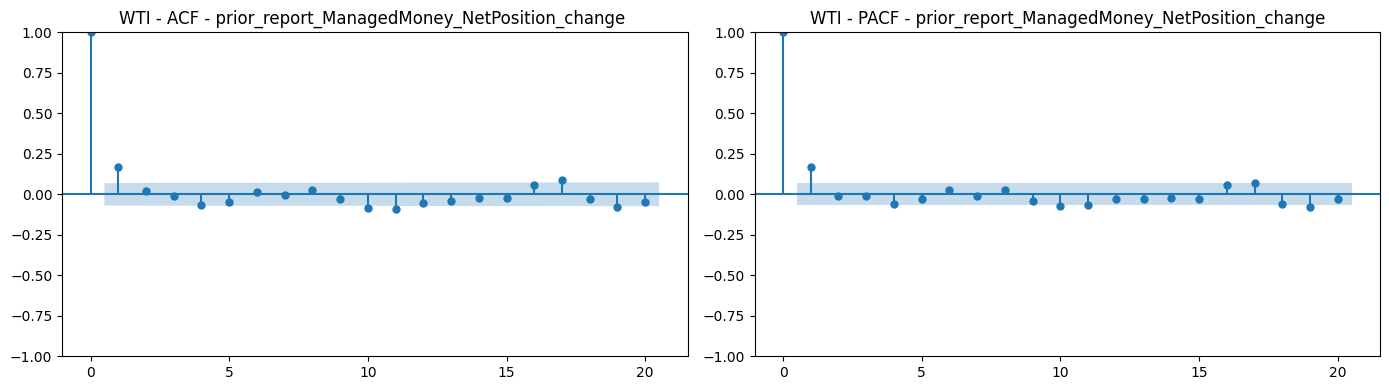

In [36]:

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(dataset['prior_report_ManagedMoney_NetPosition_change'].dropna(), lags=20, ax=axes[0])
axes[0].set_title("WTI - ACF - prior_report_ManagedMoney_NetPosition_change ")

plot_pacf(dataset['prior_report_ManagedMoney_NetPosition_change'].dropna(), lags=20, ax=axes[1], method='ywm')  # 'ywm' is robust
axes[1].set_title("WTI - PACF - prior_report_ManagedMoney_NetPosition_change")

plt.tight_layout()
plt.show()

In [37]:
get_features_responses_correlation(dataset= dataset,
                                    features =  ['Commercial_NetPosition', 
                                                'CommercialLongPosition', 
                                                'CommercialShortPosition'],
                                    responses = [ 'ManagedMoney_NetPosition',
                                                    'ManagedMoney_LongPosition', 
                                                    'ManagedMoney_ShortPosition'])

,Feature,ManagedMoney_NetPosition,ManagedMoney_LongPosition,ManagedMoney_ShortPosition
0,Commercial_NetPosition,0.099788,0.014632,-0.222799
1,CommercialLongPosition,0.256465,0.215370,-0.057059
2,CommercialShortPosition,0.184055,0.228619,0.189722


In [39]:
get_features_responses_correlation(dataset=dataset,
                                    features =  ['prior_report_Commercial_NetPosition_change', 
                                                'prior_report_CommercialLongPosition_change', 
                                                'prior_report_CommercialShortPosition_change'],
                                    responses = [ 'prior_report_ManagedMoney_NetPosition_change',
                            'prior_report_ManagedMoney_LongPosition_change', 
                            'prior_report_ManagedMoney_ShortPosition_change'])

,Feature,prior_report_ManagedMoney_NetPosition_change,prior_report_ManagedMoney_LongPosition_change,prior_report_ManagedMoney_ShortPosition_change
0,prior_report_Commercial_NetPosition_change,0.002810,-0.024653,-0.027327
1,prior_report_CommercialLongPosition_change,0.018638,0.007425,-0.019378
2,prior_report_CommercialShortPosition_change,0.030515,0.028445,-0.014798


In [ ]:
commercial_mm_net_position_correlation = []
commercial_mm_long_position_correlation = []
commercial_mm_short_position_correlation = []
year_trail = []
for (y,gp) in wti_cot_db.groupby('year'):
    year_trail.append(y)
    print(f'{y}')
    correlation_df=get_features_responses_correlation(dataset=gp,
                                    features =  ['WTI_Commercial_NetPosition' ],
                                    responses = [ 'WTI_ManagedMoney_NetPosition'])
    commercial_mm_net_position_correlation.append(correlation_df.iloc[0,1])
    long_correlation_df=get_features_responses_correlation(dataset=gp,
                                    features =  ['WTI_CommercialLongPosition' ],
                                    responses = [ 'WTI_ManagedMoney_LongPosition'])
    commercial_mm_long_position_correlation.append(long_correlation_df.iloc[0,1])
    short_correlation_df=get_features_responses_correlation(dataset=gp,
                                    features =  ['WTI_CommercialShortPosition' ],
                                    responses = [ 'WTI_ManagedMoney_ShortPosition'])
    commercial_mm_short_position_correlation.append(short_correlation_df.iloc[0,1])    
    
    

In [ ]:
commercial_mm_net_position_correlation_df=pd.DataFrame({'year':year_trail,
'commercial_mm_net_position_correlation':commercial_mm_net_position_correlation})

In [ ]:
commercial_mm_long_position_correlation_df=pd.DataFrame({'year':year_trail,
'commercial_mm_long_position_correlation':commercial_mm_long_position_correlation})

In [ ]:
commercial_mm_short_position_correlation_df=pd.DataFrame({'year':year_trail,
'commercial_mm_short_position_correlation':commercial_mm_short_position_correlation})

In [ ]:
plt.plot(commercial_mm_net_position_correlation_df['year'],
         commercial_mm_net_position_correlation_df['commercial_mm_net_position_correlation'],'-')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.title('Commercial vs Managed Money Net Position Correlation')
         

In [ ]:
plt.plot(commercial_mm_long_position_correlation_df['year'],
         commercial_mm_long_position_correlation_df['commercial_mm_long_position_correlation'],'-')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.title('Commercial vs Managed Money Long Position Correlation')
         

In [ ]:
plt.plot(commercial_mm_short_position_correlation_df['year'],
         commercial_mm_short_position_correlation_df['commercial_mm_short_position_correlation'],'-')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.title('Commercial vs Managed Money Short Position Correlation')
         

In [ ]:
commercial_mm_net_position_change_correlation = []
commercial_mm_long_position_change_correlation = []
commercial_mm_short_position_change_correlation = []
year_trail = []
for (y,gp) in wti_cot_db.groupby('year'):
    year_trail.append(y)
    print(f'{y}')
    net_change_correlation_df=get_features_responses_correlation(dataset=gp,
                                    features =  ['prior_report_WTI_Commercial_NetPosition_change' ],
                                    responses = [ 'prior_report_WTI_ManagedMoney_NetPosition_change'])
    commercial_mm_net_position_change_correlation.append(net_change_correlation_df.iloc[0,1])
    long_change_correlation_df=get_features_responses_correlation(dataset=gp,
                                    features =  ['prior_report_WTI_CommercialLongPosition_change' ],
                                    responses = [ 'prior_report_WTI_ManagedMoney_LongPosition_change'])
    commercial_mm_long_position_change_correlation.append(long_change_correlation_df.iloc[0,1])
    short_change_correlation_df=get_features_responses_correlation(dataset=gp,
                                    features =  ['prior_report_WTI_CommercialShortPosition_change' ],
                                    responses = [ 'prior_report_WTI_ManagedMoney_ShortPosition_change'])
    commercial_mm_short_position_change_correlation.append(short_change_correlation_df.iloc[0,1])    

In [ ]:
commercial_mm_net_position_change_correlation_df=pd.DataFrame({'year':year_trail,
'commercial_mm_net_position_change_correlation':commercial_mm_net_position_change_correlation})

In [ ]:
commercial_mm_long_position_change_correlation_df=pd.DataFrame({'year':year_trail,
'commercial_mm_long_position_change_correlation':commercial_mm_long_position_change_correlation})

In [ ]:
commercial_mm_short_position_change_correlation_df=pd.DataFrame({'year':year_trail,
'commercial_mm_short_position_change_correlation':commercial_mm_short_position_change_correlation})

In [ ]:
plt.plot(commercial_mm_net_position_change_correlation_df['year'],
         commercial_mm_net_position_change_correlation_df['commercial_mm_net_position_change_correlation'],'-')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.title('Commercial vs Managed Money Net Position Correlation')
         

In [ ]:
plt.plot(commercial_mm_long_position_change_correlation_df['year'],
         commercial_mm_long_position_change_correlation_df['commercial_mm_long_position_change_correlation'],'-')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.title('Commercial vs Managed Money Long Position Correlation')

In [ ]:
plt.plot(commercial_mm_short_position_change_correlation_df['year'],
         commercial_mm_short_position_change_correlation_df['commercial_mm_short_position_change_correlation'],'-')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.title('Commercial vs Managed Money Short Position Correlation')

In [ ]:
sasa

In [ ]:
cot_db = pd.read_csv('../cache/raw_data/cot_db.csv')

In [ ]:
volume_db = pd.read_csv('../cache/raw_data/volume_db.csv')

In [ ]:
oi_db = pd.read_csv('../cache/raw_data/oi_db.csv')

In [ ]:
oi_db

In [ ]:
raw_data = pd.read_csv('../cache/raw_data/index_roll_data.csv')

In [ ]:
raw_data.shape

In [ ]:
raw_data.columns.tolist()

In [ ]:
raw_data.isna().sum()

In [ ]:
raw_data.isnull().sum()

In [ ]:
raw_data.columns =['tradeDate', 
                   'CL1_Price',
                   'CL2_Price', 
                   'CL3_Price', 
                   'CL1_RolledPrice', 
                   'CL2_RolledPrice',
                    'CL3_RolledPrice', 
                    'WTI_Commercial_NetPosition', 
                    'WTI_CommercialLongPosition', 
                    'WTI_CommercialShortPosition', 
                    'WTI_ManagedMoney_NetPosition',
                    'WTI_ManagedMoney_LongPosition', 
                    'WTI_ManagedMoney_ShortPosition']

In [ ]:
raw_data['tradeDate'] = pd.to_datetime(raw_data['tradeDate']).dt.date

In [ ]:
min_date = raw_data['tradeDate'].min()
max_date = raw_data['tradeDate'].max()

In [ ]:
raw_data.shape

In [ ]:
business_dates = get_business_dates(start_date=min_date, end_date=max_date)

In [ ]:
set(set(raw_data['tradeDate'].unique().tolist()) - set(business_dates))

In [ ]:
raw_data['dayOfWeek'] = pd.to_datetime(raw_data['tradeDate']).dt.day_name()

In [ ]:
import collections

In [ ]:
collections.Counter(raw_data['dayOfWeek'])

In [ ]:
raw_data.sort_values(by= 'tradeDate', ascending = True, inplace = True) 

In [ ]:
positioning_data = raw_data[['tradeDate',
           'dayOfWeek', 
 'WTI_Commercial_NetPosition',
 'WTI_CommercialLongPosition',
 'WTI_CommercialShortPosition',
 'WTI_ManagedMoney_NetPosition',
 'WTI_ManagedMoney_LongPosition',
 'WTI_ManagedMoney_ShortPosition'
]].dropna()

In [ ]:
positioning_data.sort_values(by= 'tradeDate', ascending = True, inplace = True) 

In [ ]:
positioning_data['prior_period_WTI_Commercial_NetPosition_change'] = positioning_data['WTI_Commercial_NetPosition'] -positioning_data['WTI_Commercial_NetPosition'].shift(1)
positioning_data['prior_period_WTI_Commercial_LongPosition_change'] = positioning_data['WTI_CommercialLongPosition'] -positioning_data['WTI_CommercialLongPosition'].shift(1)
positioning_data['prior_period_WTI_Commercial_ShortPosition_change'] = positioning_data['WTI_CommercialShortPosition'] -positioning_data['WTI_CommercialShortPosition'].shift(1)

In [ ]:
positioning_data['prior_period_WTI_ManagedMoney_NetPosition_change'] = positioning_data['WTI_ManagedMoney_NetPosition'] -positioning_data['WTI_ManagedMoney_NetPosition'].shift(1)
positioning_data['prior_period_WTI_ManagedMoney_LongPosition_change'] = positioning_data['WTI_ManagedMoney_LongPosition'] -positioning_data['WTI_ManagedMoney_LongPosition'].shift(1)
positioning_data['prior_period_WTI_ManagedMoney_ShortPosition_change'] = positioning_data['WTI_ManagedMoney_ShortPosition'] -positioning_data['WTI_ManagedMoney_ShortPosition'].shift(1)

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'ds': pd.to_datetime(positioning_data['tradeDate']),
    'y': positioning_data['prior_period_WTI_ManagedMoney_NetPosition_change']
}).dropna()


In [ ]:
df_prophet = positioning_data[['tradeDate',
                               'prior_period_WTI_Commercial_NetPosition_change']].rename(columns={'tradeDate': 'ds',
                                                                                                    
                                                                                                    'prior_period_WTI_Commercial_NetPosition_change': 'y'})


In [ ]:
df_prophet

In [ ]:
m = Prophet( )
m.fit(df_prophet)
forecast = m.predict(df_prophet)



In [ ]:
_=m.plot_components(forecast)

In [ ]:
from prophet import Prophet

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series (replace with your data)
np.random.seed(42)
ts = pd.Series(np.random.randn(100).cumsum())

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(positioning_data['prior_period_WTI_Commercial_NetPosition_change'].dropna(), lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(positioning_data['prior_period_WTI_Commercial_NetPosition_change'].dropna(), lags=20, ax=axes[1], method='ywm')  # 'ywm' is robust
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series (replace with your data)
np.random.seed(42)
ts = pd.Series(np.random.randn(100).cumsum())

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(positioning_data['prior_period_WTI_ManagedMoney_LongPosition_change'].dropna(), lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(positioning_data['prior_period_WTI_ManagedMoney_LongPosition_change'].dropna(), lags=20, ax=axes[1], method='ywm')  # 'ywm' is robust
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series (replace with your data)
np.random.seed(42)
ts = pd.Series(np.random.randn(100).cumsum())

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(positioning_data['prior_period_WTI_ManagedMoney_ShortPosition_change'].dropna(), lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(positioning_data['prior_period_WTI_ManagedMoney_ShortPosition_change'].dropna(), lags=20, ax=axes[1], method='ywm')  # 'ywm' is robust
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series (replace with your data)
np.random.seed(42)
ts = pd.Series(np.random.randn(100).cumsum())

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(positioning_data['prior_period_WTI_ManagedMoney_NetPosition_change'].dropna(), lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(positioning_data['prior_period_WTI_ManagedMoney_NetPosition_change'].dropna(), lags=20, ax=axes[1], method='ywm')  # 'ywm' is robust
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings

def walk_forward_arma_prediction(series: pd.Series, burn_in: int = 100):
    """
    Perform walk-forward prediction using ARMA(1,1) on a given time series and plot the results.

    Parameters:
        series (pd.Series): The time series data.
        burn_in (int): Number of initial points to skip for fitting.

    Returns:
        Tuple[pd.Series, Optional[float]]: The predicted values and final MSE if computable.
    """
    predictions = []
    true_values = []
    indices = []

    for t in range(burn_in, len(series) - 1):
        train_data = series.iloc[:t+1]
        

                
        model = ARIMA(train_data, order=(1, 0, 1))
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1).iloc[0]
                


        predictions.append(yhat)
        true_values.append(series.iloc[t + 1])
        indices.append(series.index[t + 1])

    # Create Series
    predictions = pd.Series(predictions, index=indices)
    true_values = pd.Series(true_values, index=indices)

    # Drop NaNs
    mask = predictions.notna()
    predictions = predictions[mask]
    true_values = true_values[mask]

    if len(predictions) == 0:
        print("❌ All predictions failed. Cannot compute MSE or plot.")
        return predictions, None

    mse = mean_squared_error(true_values, predictions)
    print(f"✅ Valid predictions: {len(predictions)} | MSE = {mse:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label="Actual", linewidth=2)
    plt.plot(predictions, label="Predicted", linestyle='--')
    plt.title(f"ARMA(1,1) Walk-Forward Prediction\nMSE = {mse:.4f}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
        # Plot 2: Scatter plot (parity plot)
    plt.figure(figsize=(6, 6))
    plt.scatter(true_values, predictions, alpha=0.6)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()],
             linestyle='--', color='red', label='Ideal')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return true_values,predictions, mse


In [ ]:
positioning_data['prior_period_WTI_ManagedMoney_NetPosition_change'].dropna()

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess

# np.random.seed(42)
# ar = np.array([1, -0.7])
# ma = np.array([1, 0.5])
# arma_process = ArmaProcess(ar, ma)
# series = pd.Series(arma_process.generate_sample(nsample=500))

true_values,predictions, mse = walk_forward_arma_prediction(positioning_data['prior_period_WTI_Commercial_NetPosition_change'].dropna().reset_index(drop=True), burn_in=100)

In [ ]:
from research.plots import plot_bin_summary_of_xy

In [ ]:
_=plot_bin_summary_of_xy(x=positioning_data['prior_period_WTI_Commercial_NetPosition_change'],
                       y=positioning_data['prior_period_WTI_ManagedMoney_NetPosition_change'],
                       k=10,
                        xlabel='prior_period_WTI_Commercial_NetPosition_change',
                        ylabel='prior_period_WTI_ManagedMoney_NetPosition_change' )
                       

In [ ]:
_=plot_bin_summary_of_xy(x=positioning_data['prior_period_WTI_Commercial_LongPosition_change'],
                       y=positioning_data['prior_period_WTI_ManagedMoney_ShortPosition_change'],
                       k=10,
                        xlabel='prior_period_WTI_Commercial_LongPosition_change',
                        ylabel='prior_period_WTI_ManagedMoney_ShortPosition_change' )

In [ ]:
_=plot_bin_summary_of_xy(x=positioning_data['prior_period_WTI_Commercial_ShortPosition_change'],
                       y=positioning_data['prior_period_WTI_ManagedMoney_LongPosition_change'],
                       k=10,
                        xlabel='prior_period_WTI_Commercial_ShortPosition_change',
                        ylabel='prior_period_WTI_ManagedMoney_LongPosition_change' )

In [ ]:
_=plot_bin_summary_of_xy(x=predictions,
                       y=true_values,
                       k=10,
                        xlabel='Prediction',
                        ylabel='Actual',
                        title='Commercial Net prediction with ARMA(1,1)')
                       

In [ ]:
positioning_data

In [ ]:
for f in [  'CL1_Price',
                   'CL2_Price', 
                   'CL3_Price', 
                   'CL1_RolledPrice', 
                   'CL2_RolledPrice',
                    'CL3_RolledPrice', 
                    'WTI_Commercial_NetPosition', 
                    'WTI_CommercialLongPosition', 
                    'WTI_CommercialShortPosition', 
                    'WTI_ManagedMoney_NetPosition',
                    'WTI_ManagedMoney_LongPosition', 
                    'WTI_ManagedMoney_ShortPosition']:
    plt.hist(raw_data[f], bins = 100, log =True)
    plt.title(f)
    plt.show()
    plt.close()

In [ ]:
for f in [  'CL1_Price',
                   'CL2_Price', 
                   'CL3_Price', 
                   'CL1_RolledPrice', 
                   'CL2_RolledPrice',
                    'CL3_RolledPrice']:
    raw_data[f'prior_5D_{f}_change']=raw_data[f'{f}'] - raw_data[f'{f}'].shift(5)
for w in [1,2,3,4,5,10,15,20]:
    for f in [  'CL1_Price',
                   'CL2_Price', 
                   'CL3_Price', 
                   'CL1_RolledPrice', 
                   'CL2_RolledPrice',
                    'CL3_RolledPrice']:
        raw_data[f'next_{w}D_{f}_change']= raw_data[f'{f}'].shift(-w) - raw_data[f'{f}'] 
        raw_data[f'prior_{w}D_{f}_change']= raw_data[f'{f}']  - raw_data[f'{f}'].shift(w) 

In [ ]:
raw_data[[
                    'WTI_Commercial_NetPosition', 
                    'WTI_CommercialLongPosition', 
                    'WTI_CommercialShortPosition', 
                    'WTI_ManagedMoney_NetPosition',
                    'WTI_ManagedMoney_LongPosition', 
                    'WTI_ManagedMoney_ShortPosition']].corr()

In [ ]:
from research.metrics import get_features_responses_correlation

In [ ]:
raw_data.columns.tolist()

In [ ]:
?get_features_responses_correlation

In [ ]:
raw_data=pd.merge(raw_data,
            positioning_data[['tradeDate',
             'prior_period_WTI_Commercial_NetPosition_change',
                             'prior_period_WTI_Commercial_LongPosition_change',
                             'prior_period_WTI_Commercial_ShortPosition_change',
                               'prior_period_WTI_ManagedMoney_NetPosition_change',
                             'prior_period_WTI_ManagedMoney_LongPosition_change',
                             'prior_period_WTI_ManagedMoney_ShortPosition_change',
                             
                             ]],
         on = 'tradeDate',
         how ='inner')

In [ ]:
cl1_responses=[f'next_{w}D_CL1_RolledPrice_change' for w in [1,2,3,4,5,10,15,20] ] 
cl2_responses=[f'next_{w}D_CL2_RolledPrice_change' for w in [1,2,3,4,5,10,15,20] ] 
spread_responses=[f'next_{w}D_CL1MinusCL2_RolledPrice_change' for w in [1,2,3,4,5,10,15,20] ] 
prior_cl1_responses=[f'prior_{w}D_CL1_RolledPrice_change' for w in [1,2,3,4,5,10,15,20] ] 
prior_cl2_responses=[f'prior_{w}D_CL2_RolledPrice_change' for w in [1,2,3,4,5,10,15,20] ] 
prior_spread_responses=[f'prior_{w}D_CL1MinusCL2_RolledPrice_change' for w in [1,2,3,4,5,10,15,20] ] 


In [ ]:
for w in [1,2,3,4,5,10,15,20]:
    raw_data[f'next_{w}D_CL1MinusCL2_RolledPrice_change'] = raw_data[f'next_{w}D_CL1_RolledPrice_change']-raw_data[f'next_{w}D_CL2_RolledPrice_change']
for w in [1,2,3,4,5,10,15,20]:
    raw_data[f'prior_{w}D_CL1MinusCL2_RolledPrice_change'] = raw_data[f'prior_{w}D_CL1_RolledPrice_change']-raw_data[f'prior_{w}D_CL2_RolledPrice_change']

In [ ]:
get_features_responses_correlation(
    dataset = raw_data,
    features = ['prior_period_WTI_Commercial_NetPosition_change','prior_period_WTI_Commercial_LongPosition_change',
                             'prior_period_WTI_Commercial_ShortPosition_change'],
    responses = spread_responses ).T

In [ ]:
get_features_responses_correlation(
    dataset = raw_data,
    features = ['prior_period_WTI_Commercial_NetPosition_change','prior_period_WTI_Commercial_LongPosition_change',
                             'prior_period_WTI_Commercial_ShortPosition_change'],
    responses = prior_cl1_responses ).T

In [ ]:
get_features_responses_correlation(
    dataset = raw_data,
    features = ['prior_period_WTI_Commercial_NetPosition_change','prior_period_WTI_Commercial_LongPosition_change',
                             'prior_period_WTI_Commercial_ShortPosition_change'],
    responses = prior_spread_responses ).T

In [ ]:
get_features_responses_correlation(
    dataset = raw_data,
    features = ['prior_period_WTI_Commercial_NetPosition_change','prior_period_WTI_Commercial_LongPosition_change',
                             'prior_period_WTI_Commercial_ShortPosition_change'],
    responses = prior_cl1_responses ).T

In [ ]:
get_features_responses_correlation(
    dataset = raw_data,
    features = [ 'prior_period_WTI_ManagedMoney_NetPosition_change',
                             'prior_period_WTI_ManagedMoney_LongPosition_change',
                             'prior_period_WTI_ManagedMoney_ShortPosition_change'],
    responses = spread_responses ).T

In [ ]:
get_features_responses_correlation(
    dataset = raw_data,
    features = [ 'prior_period_WTI_ManagedMoney_NetPosition_change',
                             'prior_period_WTI_ManagedMoney_LongPosition_change',
                             'prior_period_WTI_ManagedMoney_ShortPosition_change'],
    responses = prior_spread_responses ).T